# Inicio

In [ ]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columnas = ["attack_time", "watcher_country", "watcher_as_name", "attacker_country", "attacker_as_name", "attack_type", "watcher_uuid_enum", "attacker_ip_enum"]
X_test = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/test.parq", columns = columnas)
X_test = X_test.drop_duplicates(subset = ["attacker_ip_enum"])
X_test = X_test.sort_values(by = "attacker_ip_enum")
X_test

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum
21502,2023-08-05 01:06:05+00:00,US,GOOGLE,KH,ANGKOR DATA COMMUNICATION,http:bruteforce,11357,5
191,2023-07-30 07:48:36+00:00,LU,PONYNET,CA,OVH SAS,ssh:bruteforce,259,7
665517,2023-08-24 22:34:25+00:00,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,http:scan,24879,21
72758,2023-07-31 15:06:25+00:00,US,A2HOSTING,IN,Threesa Infoway Pvt.Ltd.,http:spam,6292,29
37390,2023-07-31 12:51:27+00:00,GB,DIGITALOCEAN-ASN,CZ,"Seznam.cz, a.s.",http:spam,6570,33
...,...,...,...,...,...,...,...,...
17869691,2023-08-02 19:20:11+00:00,US,CONTABO,BR,GOOGLE,unknown:unknown,332,199947
17977618,2023-08-29 01:54:37+00:00,DE,Hetzner Online GmbH,ZA,Afrihost,ssh:bruteforce,69717,199949
17862033,2023-08-02 01:09:27+00:00,US,GOOGLE-CLOUD-PLATFORM,GB,Constantine Cybersecurity Ltd.,http:spam,6249,199962
17857346,2023-08-03 00:41:02+00:00,HK,AMAZON-02,BH,Kalaam Telecom Bahrain B.S.C.,http:spam,39538,199964


In [ ]:
X_test_ip = X_test[["attacker_ip_enum"]]
X_test_ip

,attacker_ip_enum
21502,5
191,7
665517,21
72758,29
37390,33
...,...
17869691,199947
17977618,199949
17862033,199962
17857346,199964


Para test y train, creo varias features: hora, rango de horas, día de la semana, divido tipo de ataque en protocolo y ataque, y país del atacante junto a la hora del ataque. Para las dos columnas de países, había diez que aparecían más veces, así que los que sobraban los agrupé en Otros países. Para la imputación de nulos de las dos columnas de nombres, tomé en cuenta al nombre que aparecía más veces en el país respectivo y le asigné ese. También cambié los tipos de todas las columnas para ahorrar memoria.

In [ ]:
X_test["hour"] = X_test["attack_time"].dt.hour.astype("category")
X_test["hour_range"] = pd.cut(X_test["hour"], bins = [-1, 6, 12, 18, 23], labels = ["(0-6)","(6-12)", "(12-18)", "(18-0)"]).astype("category")
X_test["day"] = X_test["attack_time"].dt.day_name().astype("category")
X_test[["protocol", "attack"]] = X_test["attack_type"].str.split(":", expand = True).astype("category")

paises_attacker = ["US", "CA", "RU", "SG", "DE", "AU", "CN", "IN", "FR", "NL"]
paises_watcher = ["US", "DE", "FR", "GB", "NL", "PL", "CA", "SG", "RU", "BE"]
X_test["attacker_country"] = np.where(X_test["attacker_country"].isin(paises_attacker), X_test["attacker_country"], "Otros países")
X_test["attacker_country"] = X_test["attacker_country"].astype("category")
X_test["watcher_country"] = np.where(X_test["watcher_country"].isin(paises_watcher), X_test["watcher_country"], "Otros países")
X_test["watcher_country"] = X_test["watcher_country"].astype("category")

X_test["attacker_as_name"] = X_test.groupby("attacker_country")["attacker_as_name"].transform(lambda x: x.fillna(x.mode()[0]))
X_test["watcher_as_name"] = X_test.groupby("watcher_country")["watcher_as_name"].transform(lambda x: x.fillna(x.mode()[0]))

batches = np.array_split(X_test, 100)
batches_juntos = []
for batch in batches:
    batch["attacker_country_hour"] = batch["attacker_country"].astype(str) + "/" + batch["hour"].astype(str)
    batches_juntos.append(batch)
X_test = pd.concat(batches_juntos)
X_test["attacker_country_hour"] = X_test["attacker_country_hour"].astype("category")

X_test = X_test.drop(["attack_type", "attack_time", "attacker_ip_enum"], axis = 1)
X_test

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
21502,US,GOOGLE,Otros países,ANGKOR DATA COMMUNICATION,11357,1,(0-6),Saturday,http,bruteforce,Otros países/1
191,Otros países,PONYNET,CA,OVH SAS,259,7,(6-12),Sunday,ssh,bruteforce,CA/7
665517,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,24879,22,(18-0),Thursday,http,scan,DE/22
72758,US,A2HOSTING,IN,Threesa Infoway Pvt.Ltd.,6292,15,(12-18),Monday,http,spam,IN/15
37390,GB,DIGITALOCEAN-ASN,Otros países,"Seznam.cz, a.s.",6570,12,(6-12),Monday,http,spam,Otros países/12
...,...,...,...,...,...,...,...,...,...,...,...
17869691,US,CONTABO,Otros países,GOOGLE,332,19,(18-0),Wednesday,unknown,unknown,Otros países/19
17977618,DE,Hetzner Online GmbH,Otros países,Afrihost,69717,1,(0-6),Tuesday,ssh,bruteforce,Otros países/1
17862033,US,GOOGLE-CLOUD-PLATFORM,Otros países,Constantine Cybersecurity Ltd.,6249,1,(0-6),Wednesday,http,spam,Otros países/1
17857346,Otros países,AMAZON-02,Otros países,Kalaam Telecom Bahrain B.S.C.,39538,0,(0-6),Thursday,http,spam,Otros países/0


In [ ]:
columnas = ["attack_time", "watcher_country", "watcher_as_name", "attacker_country", "attacker_as_name", "attack_type", "watcher_uuid_enum", "attacker_ip_enum", "label"]
train = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/train.parq", columns = columnas)
train

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:exploit,2,4637,0
...,...,...,...,...,...,...,...,...,...
61629680,2023-08-24 21:14:52+00:00,DE,ENTEGA Medianet GmbH,DE,Vodafone GmbH,http:scan,24879,190784,0
61629681,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:scan,40383,193446,0
61629682,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:spam,40383,193446,0
61629683,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:spam,40383,193446,0


Como voy a splitear el train para conseguir el set de validación, dropeo los duplicados para que no queden separados en diferentes sets y termine validando con la data aprendida en el entrenamiento.

In [ ]:
train = train.drop_duplicates()
train = train.copy()
train

,attack_time,watcher_country,watcher_as_name,attacker_country,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,Host Europe GmbH,TR,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,http:exploit,2,4637,0
...,...,...,...,...,...,...,...,...,...
61629671,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:bruteforce,9606,191439,0
61629673,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:scan,9606,191439,0
61629674,2023-08-24 21:14:59+00:00,US,INMOTION,US,ATT-INTERNET4,http:exploit,9606,191439,0
61629681,2023-08-24 21:14:46+00:00,US,NAMECHEAP-NET,US,WOW,http:scan,40383,193446,0


In [ ]:
train["hour"] = train["attack_time"].dt.hour.astype("category")
train["hour_range"] = pd.cut(train["hour"], bins = [-1, 6, 12, 18, 23], labels = ["(0-6)","(6-12)", "(12-18)", "(18-0)"]).astype("category")
train["day"] = train["attack_time"].dt.day_name().astype("category")
train[["protocol", "attack"]] = train["attack_type"].str.split(":", expand = True).astype("category")

train["attacker_country"] = np.where(train["attacker_country"].isin(paises_attacker), train["attacker_country"], "Otros países")
train["attacker_country"] = train["attacker_country"].astype("category")
train["watcher_country"] = np.where(train["watcher_country"].isin(paises_watcher), train["watcher_country"], "Otros países")
train["watcher_country"] = train["watcher_country"].astype("category")

train["attacker_as_name"] = train.groupby("attacker_country")["attacker_as_name"].transform(lambda x: x.fillna(x.mode()[0]))
train["watcher_as_name"] = train.groupby("watcher_country")["watcher_as_name"].transform(lambda x: x.fillna(x.mode()[0]))

batches = np.array_split(train, 100)
batches_juntos = []
for batch in batches:
    batch["attacker_country_hour"] = batch["attacker_country"].astype(str) + "/" + batch["hour"].astype(str)
    batches_juntos.append(batch)
train = pd.concat(batches_juntos)
train["attacker_country_hour"] = train["attacker_country_hour"].astype("category")

train = train.drop(["attack_type", "attack_time"], axis = 1)
train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,attacker_ip_enum,label,hour,hour_range,day,protocol,attack,attacker_country_hour
0,DE,Host Europe GmbH,Otros países,Murat Aktas,0,6466,0,7,(6-12),Monday,http,exploit,Otros países/7
1,DE,Host Europe GmbH,Otros países,Murat Aktas,0,6466,0,7,(6-12),Monday,http,spam,Otros países/7
2,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,2,4637,0,7,(6-12),Monday,http,bruteforce,DE/7
3,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,2,4637,0,7,(6-12),Monday,http,spam,DE/7
4,DE,bn:t Blatzheim Networks Telecom GmbH,DE,Contabo GmbH,2,4637,0,7,(6-12),Monday,http,exploit,DE/7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629671,US,INMOTION,US,ATT-INTERNET4,9606,191439,0,21,(18-0),Thursday,http,bruteforce,US/21
61629673,US,INMOTION,US,ATT-INTERNET4,9606,191439,0,21,(18-0),Thursday,http,scan,US/21
61629674,US,INMOTION,US,ATT-INTERNET4,9606,191439,0,21,(18-0),Thursday,http,exploit,US/21
61629681,US,NAMECHEAP-NET,US,WOW,40383,193446,0,21,(18-0),Thursday,http,scan,US/21


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40290308 entries, 0 to 61629682
Data columns (total 13 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   watcher_country        category
 1   watcher_as_name        category
 2   attacker_country       category
 3   attacker_as_name       category
 4   watcher_uuid_enum      int32   
 5   attacker_ip_enum       int32   
 6   label                  int8    
 7   hour                   category
 8   hour_range             category
 9   day                    category
 10  protocol               category
 11  attack                 category
 12  attacker_country_hour  category
dtypes: category(10), int32(2), int8(1)
memory usage: 1.1 GB


# División de Train y Validation

¿Cómo conviene obtener el dataset para validar? Conviene splitear los IPs únicos para que estén todos en el set de test o el de validation, y que no queden divididos en ambos.

In [ ]:
train_set, validation_set = train_test_split(train["attacker_ip_enum"].unique(), test_size = 0.2, random_state = 18)

X_train = train[train["attacker_ip_enum"].isin(train_set)].drop("attacker_ip_enum", axis = 1)
X_validation = train[train["attacker_ip_enum"].isin(validation_set)].drop(["attacker_ip_enum", "label"], axis = 1)
y_validation = train[train["attacker_ip_enum"].isin(validation_set)]["label"]

label_zero = X_train.loc[X_train["label"] == 0]
label_one = X_train.loc[X_train["label"] == 1]

label_zero = resample(label_zero, replace = False, n_samples = len(label_one), random_state = 18)

X_train = pd.concat([label_zero, label_one])
y_train = X_train["label"]
X_train = X_train.drop("label", axis = 1)

In [ ]:
del train
del batch
del batches
del batches_juntos

In [ ]:
X_train

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
49868872,FR,Host Europe GmbH,Otros países,Ans Academy Limited,3842,14,(12-18),Friday,http,exploit,Otros países/14
12933149,DE,webgo GmbH,DE,Hetzner Online GmbH,11198,6,(0-6),Wednesday,http,spam,DE/6
55821067,FR,OVH SAS,Otros países,PT Telekomunikasi Indonesia,45864,14,(12-18),Wednesday,http,exploit,Otros países/14
17126713,US,IONOS SE,US,DREAMHOST-AS,26,19,(18-0),Saturday,http,bruteforce,US/19
50649241,US,DIGITALOCEAN-ASN,CN,Chinanet,2119,15,(12-18),Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...
61629208,FR,Cyllene Lille Sasu,CA,AS-COLOCROSSING,1325,9,(6-12),Wednesday,unknown,unknown,CA/9
61629247,DE,Strato AG,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,spam,SG/21
61629250,DE,Strato AG,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,scan,SG/21
61629389,Otros países,One.com A/S,SG,DIGITALOCEAN-ASN,24258,21,(18-0),Thursday,http,scan,SG/21


In [ ]:
X_validation

,watcher_country,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
57,Otros países,Buuldy Bilisim,Otros países,VIETNAM POSTS AND TELECOMMUNICATIONS GROUP,23,7,(6-12),Monday,tcp,scan,Otros países/7
66,US,NETWORK-SOLUTIONS-HOSTING,Otros países,Telecomunicacoes de Mocambique (TDM),27,7,(6-12),Monday,http,scan,Otros países/7
67,US,NETWORK-SOLUTIONS-HOSTING,Otros países,Telecomunicacoes de Mocambique (TDM),27,7,(6-12),Monday,http,spam,Otros países/7
68,US,NETWORK-SOLUTIONS-HOSTING,Otros países,Telecomunicacoes de Mocambique (TDM),27,7,(6-12),Monday,http,bruteforce,Otros países/7
82,US,NETWORK-SOLUTIONS-HOSTING,Otros países,Telecomunicacoes de Mocambique (TDM),27,7,(6-12),Monday,http,exploit,Otros países/7
...,...,...,...,...,...,...,...,...,...,...,...
61629630,US,DIGITALOCEAN-ASN,Otros países,Tunisie-Telecom,15752,21,(18-0),Thursday,ssh,bruteforce,Otros países/21
61629654,Otros países,One Albania Sh.a.,Otros países,M247 Europe SRL,44853,21,(18-0),Thursday,tcp,scan,Otros países/21
61629657,FR,OVH SAS,DE,Host Europe GmbH,4290,21,(18-0),Thursday,http,spam,DE/21
61629658,FR,OVH SAS,DE,Host Europe GmbH,4290,21,(18-0),Thursday,http,exploit,DE/21


Para todos los encodings decidí cambiarle el tipo a cada columna para ahorrar memoria, ya que algunas quedaban con int64 o float64, dependiendo la bibliotea.

# Watcher Country

Uso Binary Encoding para watcher_country y attacker_country porque no son pocos países para usar One Hot Encoding, pero tampoco muchos para Mean Encoding.

In [ ]:
encoder = ce.BinaryEncoder(cols = ["watcher_country"])
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["watcher_country_0", "watcher_country_1", "watcher_country_2", "watcher_country_3"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,Host Europe GmbH,Otros países,Ans Academy Limited,3842,14,(12-18),Friday,http,exploit,Otros países/14
12933149,0,0,1,0,webgo GmbH,DE,Hetzner Online GmbH,11198,6,(0-6),Wednesday,http,spam,DE/6
55821067,0,0,0,1,OVH SAS,Otros países,PT Telekomunikasi Indonesia,45864,14,(12-18),Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,IONOS SE,US,DREAMHOST-AS,26,19,(18-0),Saturday,http,bruteforce,US/19
50649241,0,0,1,1,DIGITALOCEAN-ASN,CN,Chinanet,2119,15,(12-18),Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,Cyllene Lille Sasu,CA,AS-COLOCROSSING,1325,9,(6-12),Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,Strato AG,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,spam,SG/21
61629250,0,0,1,0,Strato AG,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,scan,SG/21
61629389,0,1,0,1,One.com A/S,SG,DIGITALOCEAN-ASN,24258,21,(18-0),Thursday,http,scan,SG/21


# Watcher AS Name

Uso Mean Encoding para watcher_as_name y attacker_as_name porque hay muchos nombres diferentes en cada columna.

In [ ]:
encoder = ce.TargetEncoder(cols = ["watcher_as_name"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

X_train["watcher_as_name"] = X_train["watcher_as_name"].astype("float32")
X_validation["watcher_as_name"] = X_validation["watcher_as_name"].astype("float32")
X_test["watcher_as_name"] = X_test["watcher_as_name"].astype("float32")
X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,Otros países,Ans Academy Limited,3842,14,(12-18),Friday,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,DE,Hetzner Online GmbH,11198,6,(0-6),Wednesday,http,spam,DE/6
55821067,0,0,0,1,0.470173,Otros países,PT Telekomunikasi Indonesia,45864,14,(12-18),Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,US,DREAMHOST-AS,26,19,(18-0),Saturday,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,CN,Chinanet,2119,15,(12-18),Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,CA,AS-COLOCROSSING,1325,9,(6-12),Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,spam,SG/21
61629250,0,0,1,0,0.585821,SG,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,scan,SG/21
61629389,0,1,0,1,0.479788,SG,DIGITALOCEAN-ASN,24258,21,(18-0),Thursday,http,scan,SG/21


# Attacker Country

In [ ]:
encoder = ce.BinaryEncoder(cols = ["attacker_country"])
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["attacker_country_0", "attacker_country_1", "attacker_country_2", "attacker_country_3"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,Ans Academy Limited,3842,14,(12-18),Friday,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,Hetzner Online GmbH,11198,6,(0-6),Wednesday,http,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,PT Telekomunikasi Indonesia,45864,14,(12-18),Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,DREAMHOST-AS,26,19,(18-0),Saturday,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,Chinanet,2119,15,(12-18),Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,AS-COLOCROSSING,1325,9,(6-12),Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,DIGITALOCEAN-ASN,25180,21,(18-0),Thursday,http,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,DIGITALOCEAN-ASN,24258,21,(18-0),Thursday,http,scan,SG/21


# Attacker AS Name

In [ ]:
encoder = ce.TargetEncoder(cols = ["attacker_as_name"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

X_train["attacker_as_name"] = X_train["attacker_as_name"].astype("float32")
X_validation["attacker_as_name"] = X_validation["attacker_as_name"].astype("float32")
X_test["attacker_as_name"] = X_test["attacker_as_name"].astype("float32")
X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,watcher_uuid_enum,hour,hour_range,day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,3842,14,(12-18),Friday,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,11198,6,(0-6),Wednesday,http,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,45864,14,(12-18),Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,26,19,(18-0),Saturday,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,2119,15,(12-18),Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,1325,9,(6-12),Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,21,(18-0),Thursday,http,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,21,(18-0),Thursday,http,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,24258,21,(18-0),Thursday,http,scan,SG/21


# Hour Range

Uso One Hot Encoding para hour_range, ya que solo hay cuatro valores en la columna.

In [ ]:
encoder = ce.OneHotEncoder(cols = ["hour_range"], use_cat_names = True)
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["hour_range_(0-6)", "hour_range_(6-12)", "hour_range_(12-18)", "hour_range_(18-0)"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,watcher_uuid_enum,hour,hour_range_(0-6),hour_range_(6-12),hour_range_(12-18),hour_range_(18-0),day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,3842,14,0,0,1,0,Friday,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,11198,6,1,0,0,0,Wednesday,http,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,45864,14,0,0,1,0,Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,26,19,0,0,0,1,Saturday,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,2119,15,0,0,1,0,Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,1325,9,0,1,0,0,Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,21,0,0,0,1,Thursday,http,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,21,0,0,0,1,Thursday,http,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,24258,21,0,0,0,1,Thursday,http,scan,SG/21


# Hour

Para la columna hour decidí normalizar la columna entre 0 y 1 porque hay 24 valores númericos diferentes con mucha varianza entre sí.

In [ ]:
scaler = MinMaxScaler()

X_train["hour"] = scaler.fit_transform(X_train["hour"].values.reshape(-1, 1))
X_validation["hour"] = scaler.transform(X_validation["hour"].values.reshape(-1, 1))
X_test["hour"] = scaler.transform(X_test["hour"].values.reshape(-1, 1))

X_train["hour"] = X_train["hour"].astype("float32")
X_validation["hour"] = X_validation["hour"].astype("float32")
X_test["hour"] = X_test["hour"].astype("float32")
X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,watcher_uuid_enum,hour,hour_range_(0-6),hour_range_(6-12),hour_range_(12-18),hour_range_(18-0),day,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,3842,0.608696,0,0,1,0,Friday,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,11198,0.260870,1,0,0,0,Wednesday,http,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,45864,0.608696,0,0,1,0,Wednesday,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,26,0.826087,0,0,0,1,Saturday,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,2119,0.652174,0,0,1,0,Monday,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,1325,0.391304,0,1,0,0,Wednesday,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,0.913043,0,0,0,1,Thursday,http,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,25180,0.913043,0,0,0,1,Thursday,http,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,24258,0.913043,0,0,0,1,Thursday,http,scan,SG/21


# Day

Uso Binary Encoder para la columna day porque son los siete días de la semana.

In [ ]:
encoder = ce.BinaryEncoder(cols = ["day"])
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["day_0", "day_1", "day_2"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,...,hour_range_(0-6),hour_range_(6-12),hour_range_(12-18),hour_range_(18-0),day_0,day_1,day_2,protocol,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,...,0,0,1,0,0,0,1,http,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,...,1,0,0,0,0,1,0,http,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,...,0,0,1,0,0,1,0,http,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,...,0,0,0,1,0,1,1,http,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,...,0,0,1,0,1,0,0,http,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,...,0,1,0,0,0,1,0,unknown,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,0,0,1,1,0,1,http,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,0,0,1,1,0,1,http,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,...,0,0,0,1,1,0,1,http,scan,SG/21


# Protocol

En protocol y attack uso Binary Encoding porque hay muchos datos en ambas columnas.

In [ ]:
encoder = ce.BinaryEncoder(cols = ["protocol"])
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["protocol_0", "protocol_1", "protocol_2", "protocol_3"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,...,hour_range_(18-0),day_0,day_1,day_2,protocol_0,protocol_1,protocol_2,protocol_3,attack,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,...,0,0,0,1,0,0,0,1,exploit,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,...,0,0,1,0,0,0,0,1,spam,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,...,0,0,1,0,0,0,0,1,exploit,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,...,1,0,1,1,0,0,0,1,bruteforce,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,...,0,1,0,0,0,0,0,1,spam,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,...,0,0,1,0,0,1,1,0,unknown,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,...,1,1,0,1,0,0,0,1,spam,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,...,1,1,0,1,0,0,0,1,scan,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,...,1,1,0,1,0,0,0,1,scan,SG/21


# Attack

In [ ]:
encoder = ce.BinaryEncoder(cols = ["attack"])
X_train = encoder.fit_transform(X_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

columnas = ["attack_0", "attack_1", "attack_2"]
X_train[columnas] = X_train[columnas].astype("int8")
X_validation[columnas] = X_validation[columnas].astype("int8")
X_test[columnas] = X_test[columnas].astype("int8")

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,...,day_1,day_2,protocol_0,protocol_1,protocol_2,protocol_3,attack_0,attack_1,attack_2,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,...,0,1,0,0,0,1,0,0,1,Otros países/14
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,...,1,0,0,0,0,1,0,1,0,DE/6
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,...,1,0,0,0,0,1,0,0,1,Otros países/14
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,...,1,1,0,0,0,1,0,1,1,US/19
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,...,0,0,0,0,0,1,0,1,0,CN/15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,...,1,0,0,1,1,0,1,0,1,CA/9
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,0,1,0,SG/21
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,SG/21
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,SG/21


# Attacker Country Hour

Uso Mean Encoding para attacker_country_hour y watcher_uuid_enum porque hay muchos valores diferentes.

In [ ]:
encoder = ce.TargetEncoder(cols = ["attacker_country_hour"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

X_train["attacker_country_hour"] = X_train["attacker_country_hour"].astype("float32")
X_validation["attacker_country_hour"] = X_validation["attacker_country_hour"].astype("float32")
X_test["attacker_country_hour"] = X_test["attacker_country_hour"].astype("float32")
X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,...,day_1,day_2,protocol_0,protocol_1,protocol_2,protocol_3,attack_0,attack_1,attack_2,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,...,0,1,0,0,0,1,0,0,1,0.339264
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,...,1,0,0,0,0,1,0,1,0,0.471290
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,...,1,0,0,0,0,1,0,0,1,0.339264
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,...,1,1,0,0,0,1,0,1,1,0.464070
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,...,0,0,0,0,0,1,0,1,0,0.293996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,...,1,0,0,1,1,0,1,0,1,0.513889
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,0,1,0,0.584229
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,0.584229
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,0.584229


# Watcher UUID Enum

In [ ]:
encoder = ce.TargetEncoder(cols = ["watcher_uuid_enum"])
X_train = encoder.fit_transform(X_train, y_train)
X_validation = encoder.transform(X_validation)
X_test = encoder.transform(X_test)

X_train

,watcher_country_0,watcher_country_1,watcher_country_2,watcher_country_3,watcher_as_name,attacker_country_0,attacker_country_1,attacker_country_2,attacker_country_3,attacker_as_name,...,day_1,day_2,protocol_0,protocol_1,protocol_2,protocol_3,attack_0,attack_1,attack_2,attacker_country_hour
49868872,0,0,0,1,0.561505,0,0,0,1,0.000000,...,0,1,0,0,0,1,0,0,1,0.339264
12933149,0,0,1,0,0.569955,0,0,1,0,0.024827,...,1,0,0,0,0,1,0,1,0,0.471290
55821067,0,0,0,1,0.470173,0,0,0,1,0.158694,...,1,0,0,0,0,1,0,0,1,0.339264
17126713,0,0,1,1,0.582416,0,0,1,1,0.880239,...,1,1,0,0,0,1,0,1,1,0.464070
50649241,0,0,1,1,0.469802,0,1,0,0,0.309295,...,0,0,0,0,0,1,0,1,0,0.293996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61629208,0,0,0,1,0.855536,1,0,1,1,0.907958,...,1,0,0,1,1,0,1,0,1,0.513889
61629247,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,0,1,0,0.584229
61629250,0,0,1,0,0.585821,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,0.584229
61629389,0,1,0,1,0.479788,1,0,0,1,0.710265,...,0,1,0,0,0,1,1,0,0,0.584229


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078886 entries, 49868872 to 61629390
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   watcher_country_0      1078886 non-null  int8   
 1   watcher_country_1      1078886 non-null  int8   
 2   watcher_country_2      1078886 non-null  int8   
 3   watcher_country_3      1078886 non-null  int8   
 4   watcher_as_name        1078886 non-null  float32
 5   attacker_country_0     1078886 non-null  int8   
 6   attacker_country_1     1078886 non-null  int8   
 7   attacker_country_2     1078886 non-null  int8   
 8   attacker_country_3     1078886 non-null  int8   
 9   attacker_as_name       1078886 non-null  float32
 10  watcher_uuid_enum      1078886 non-null  float64
 11  hour                   1078886 non-null  float32
 12  hour_range_(0-6)       1078886 non-null  int8   
 13  hour_range_(6-12)      1078886 non-null  int8   
 14  hour_range

# Perceptron

In [ ]:
perceptron = Perceptron()

# Random Search

Elijo estos hiperparámetros porque son los que consideré para obtener mejor score en el modelo.

In [ ]:
parametros = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "max_iter": randint(100, 2000),
    "class_weight": [None, "balanced"]
}

random_search = RandomizedSearchCV(estimator = perceptron, param_distributions = parametros, n_iter = 10, cv = 5, scoring = "f1", random_state = 18)
random_search.fit(X_train, y_train)

hiperparametros = random_search.best_params_

perceptron_optimizado = Perceptron(
    penalty = hiperparametros["penalty"],
    max_iter = hiperparametros["max_iter"],
    class_weight = hiperparametros["class_weight"]
)

perceptron_optimizado.fit(X_train, y_train)
y_prediction = perceptron_optimizado.predict(X_validation)

hiperparametros

{'class_weight': 'balanced', 'max_iter': 1826, 'penalty': 'elasticnet'}

¿Cuál es el mejor score de validación obtenido?

In [ ]:
f1_score(y_validation, y_prediction)

0.30581533877194983

In [ ]:
accuracy_score(y_validation, y_prediction)

0.9654846657053322

In [ ]:
recall_score(y_validation, y_prediction)

0.28686751090072377

In [ ]:
mean_absolute_error(y_validation, y_prediction)

0.034515334294667854

In [ ]:
mean_squared_error(y_validation, y_prediction)

0.034515334294667854

Al predecir con este modelo para test, ¿Cúal es el score obtenido? (Guardar el csv con predicciones para entregarlo después)

In [ ]:
y_prediction = perceptron_optimizado.predict(X_test)
y_prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [ ]:
predictions = pd.DataFrame({"label": y_prediction}).reset_index(drop = True)
X_test_ip = X_test_ip.reset_index(drop = True)

predicciones = pd.concat([X_test_ip, predictions], axis = 1)
predicciones

,attacker_ip_enum,label
0,5,0
1,7,0
2,21,0
3,29,0
4,33,0
...,...,...
49415,199947,0
49416,199949,0
49417,199962,0
49418,199964,0


El score obtenido es: 0.4304

In [ ]:
predicciones.to_csv("/content/drive/MyDrive/Colab Notebooks/predicciones_perceptron.csv", index = False)

In [ ]:
predicciones[predicciones["label"] == 1]

,attacker_ip_enum,label
59,299,1
93,386,1
164,645,1
174,669,1
320,1207,1
...,...,...
49253,199335,1
49254,199340,1
49363,199756,1
49395,199861,1


https://drive.google.com/file/d/15MH3XQcGKlpwhKhfRC0e9dxt640N8Vsh/view?usp=drive_link

¿Qué features son los más importantes para predecir con el mejor modelo? Graficar.

In [ ]:
feature_importance = pd.DataFrame({"feature": X_train.columns, "coefficient": perceptron_optimizado.coef_.ravel()})
feature_importance["coefficient"] = feature_importance["coefficient"].abs()
feature_importance

,feature,coefficient
0,watcher_country_0,0.000000
1,watcher_country_1,0.000000
2,watcher_country_2,0.000000
3,watcher_country_3,0.000000
4,watcher_as_name,0.964800
5,attacker_country_0,0.000000
6,attacker_country_1,0.000000
7,attacker_country_2,1.051072
8,attacker_country_3,0.366733
9,attacker_as_name,8.064482


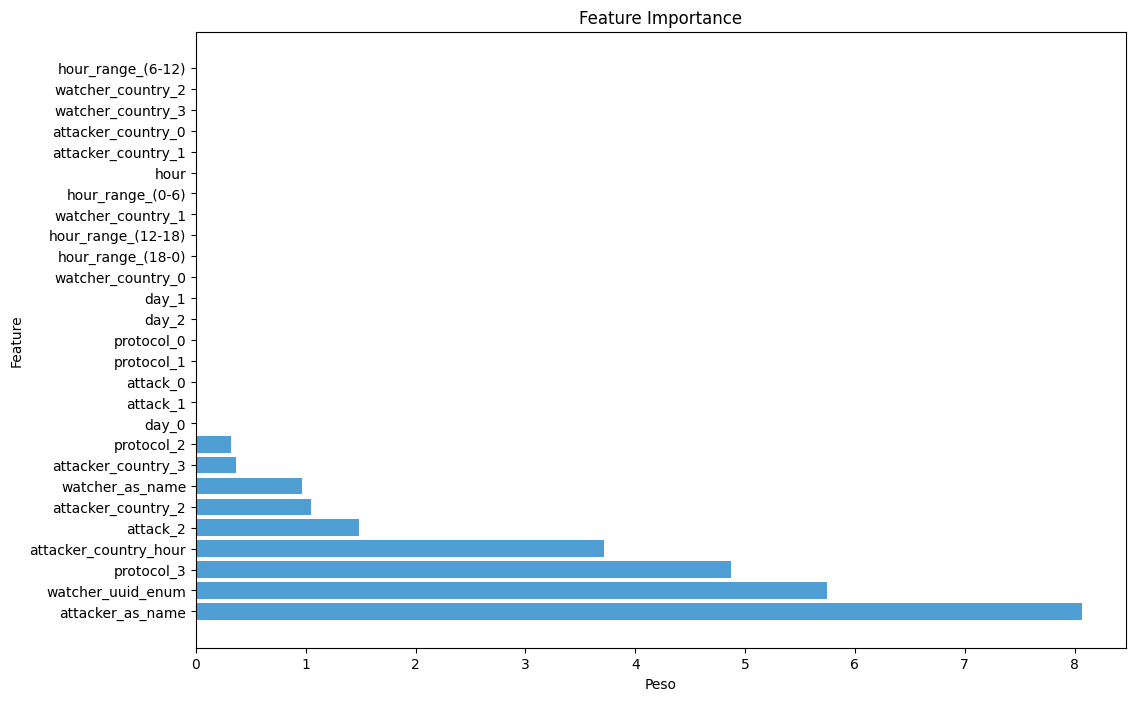

In [ ]:
feature_importance = feature_importance.reindex(feature_importance["coefficient"].sort_values(ascending = False).index)

plt.figure(figsize = (12, 8))
plt.barh(feature_importance["feature"], feature_importance["coefficient"], color = "#509FD4")
plt.title("Feature Importance")
plt.xlabel("Peso")
plt.ylabel("Feature")
plt.show()

Las features más importantes según este baseline son el attacker_as_name y watcher_uuid_enum.